# Optimal allocation revisited with a deep q-network (DQN)

In this notebook, we revisit the example of week 8 with the difference that we will implement a deep Q-learning algorithm. 

The ANN will take as input the state (last action, current price) and the next possible action.

Here is the setup:
* action: short/neutral/long the asset with a total asset exposure between $-1$ and $1$
* state: the asset price (on a finite grid) & the current position 
* environment: generate new prices and transaction costs

Remark: we do not keep track of the accumulated P&L, the objective is only to investigate if the algorithm can learn optimal decisions.

The $Q$-table is contructed as follows:

| state (prev. action \& price) / action        | $a_0=0$      | $a_1=1$   | $\cdots$   | $a_m=m$      |
| :------------------ | :----------: | -----------: | -----------: | -----------: | 
| $s_0=(0,p_{\min})$       | $Q(s_0,a_0)$ | $Q(s_0,a_1)$ | $\cdots$  | $Q(s_0,a_m)$ | 
| $s_1=(0,p_{\min} + \Delta)$       | $Q(s_1,a_0)$ | $Q(s_1,a_1)$ | $\cdots$  | $Q(s_1,a_m)$ | 
| $s_2=(0,p_{\min} + 2\Delta)$       | $Q(s_2,a_0)$ | $Q(s_2,a_1)$ | $\cdots$  | $Q(s_2,a_m)$ | 
| $\vdots$            | $\vdots$     | $\vdots$     | | $\vdots$     | 
| $s_{n-1}=(m,p_{\max}-\Delta)$  | $Q(s_{n-1},a_0)$ | $Q(s_{n-1},a_1)$ | $\cdots$  | $Q(s_{n-1},a_m)$ | 
| $s_n=(m,p_{\max})$       | $Q(s_n,a_0)$ | $Q(s_n,a_1)$ | $\cdots$  | $Q(s_n,a_m)$ | 

where $\Delta$ is the price increment.

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt

We first create a class defining the behavior of the environment. Similar logic as the `gym` environment from *OpenAI*, see https://gym.openai.com/.

In [10]:
class myTradingEnvV2:
    
    def __init__(self, timesteps_per_episode):
        """
        Initialiaze the environement
        """
        self.timesteps_per_episode = timesteps_per_episode
        self.max_price = 200. ## max price
        ##-----
        ## TODO
        ##-----
        self.mult_price = 10 ## price increment
        self.n_prices = int(self.max_price / self.mult_price + 1)
        ##-----
        ## TODO
        ##-----
        self.n_actions = 5 ## number of possible actions
        self.n_states = self.n_prices * self.n_actions ## state = (# of prices) x (# of actions)
        self.weights = np.linspace(-1, 1, self.n_actions) ## position percentage
         
    def get_state(self):
        """
        Returns the row index of the current state
        """
        price = self.prices[self.last_step]
        action = self.last_action
        idx = int(price/self.mult_price + action * self.n_prices)
        return(idx)
    
    def get_price_action(self, state):
        """
        Return the state values (current price, previous action) given a state row index
        """
        price = (state % self.n_prices) * self.mult_price
        action = state // self.n_prices
        return price, action
    
    def reset(self):
        """
        Reset the episode, random initial state values
        """
        self.prices = np.zeros(self.timesteps_per_episode)
        self.actions = np.zeros(self.timesteps_per_episode)
        self.rewards = np.zeros(self.timesteps_per_episode)
        ##---------
        ## NB: random initial state helps a lot!
        ##---------
        self.prices[0] = self.mult_price*np.random.randint(self.max_price/self.mult_price + 1) ## random inital price
        self.last_action = np.random.randint(self.n_actions) ## random initial position
        ##
        self.last_step = 0
        self.current_state = self.get_state()
        return self.current_state
    
    def step(self, a):
        """
        Generate the new state and the reward given an action *a*
        -----
        implemented:
        -> mean-reverting process
        -----
        NOT implemented:
        -> reward function
        -> transaction cost (later)
        -> borrowing cost (optional)
        -> price impact (optional)
        -> agent risk-aversion (optional)
        """
        ## get previous values
        i = self.last_step
        x = self.prices[i]
        
        ## move to next step
        if 0 < x < self.max_price:
            birth = np.random.rand() <= 0.5 + 0.1*(1. - x / self.max_price)
            death = np.random.rand() <= 0.5 + 0.1*(x / self.max_price)
            # We update the population size
            x_new = x + self.mult_price*birth - self.mult_price*death
        else:
            ## repulsive boundaries
            if x == 0:
                x_new = self.mult_price
            else:
                x_new = self.max_price - self.mult_price
        
        ##----------
        ## TODO: implement reward
        ##----------
        reward = (x_new - x) * self.weights[a]
        
        ## save action
        self.actions[i] = a
        self.last_action = a
        
        ## update step
        i += 1 
        self.last_step = i
        ## save price
        self.prices[i] = x_new
        ## save reward
        self.rewards[i] = reward
        
        ## update current state
        s_ = self.get_state()
        self.current_state = s_
        
        ## output some useful information
        info = ""
        
        ## end of the time series?
        if i == self.timesteps_per_episode - 1:
            done = True
        else:
            done = False
            
        return s_, reward, done, info
    
    def simulate(self):
        """
        FOR ILLUSTRATION ONLY
        Simulates a price trajectory, assuming no position
        """
        self.reset()
        for t in range(self.timesteps_per_episode - 1):
            self.step(0)

Let's simulate the environment.

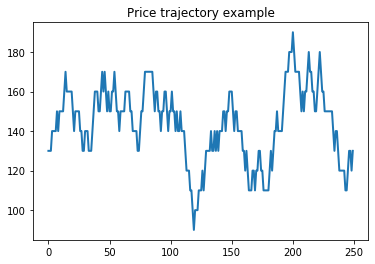

In [11]:
env = myTradingEnvV2(250) ## create environment
env.simulate() ## simulate some trajectory
plt.plot(env.prices, lw=2)
plt.title("Price trajectory example")
plt.show()

## Deep Q-learning agent

We construct the agent:
* its action-value function (ANN)
* its decision policy ($\epsilon$-greedy)
* its training routine (simple gradient-based)

In [31]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from collections import deque
import progressbar as pgb
import random as rnd

class Agent:
    
    def __init__(self, env, optimizer, gamma, epsilon):
        """
        Initialize the agent
        """
        
        ## initialize atributes
        self.env = env
        self.n_states = env.n_states
        self.n_actions = env.n_actions
        self._optimizer = optimizer
        
        ## initialize discount factor and exploration rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        ## build networks
        self.model = self._build_compile_model()
    
    def _build_compile_model(self):
        """
        Build the ANN that approximate the Q-table
        """
        ##----------
        ## TODO
        ##----------
        ## inputs:
        ##    current state:
        ##    - previous action
        ##    - current price
        ##    action:
        ##    - next action
        ## outputs:
        ##    Q-value
        ##----------
        ## create a Sequential Keras model
        model = Sequential()
        model.add(Input(3))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        ## compile the model
        model.compile(loss="mse", optimizer=self._optimizer)
        return model
    
    def act(self, state, epsilon):
        """
        epsilon-greedy algorithm
        -----
        Returns a random action with probability "epsilon",
        or returns the action that maximizes the Q-table for the row "state"
        """
        ##----------
        ## TODO
        ##----------
        if np.random.rand() <= epsilon:
            return np.random.randint(0, self.n_actions)
        ##----------
        ## TODO
        ##----------
        price, action = self.env.get_price_action(state)
        q_values = self.model.predict(np.vstack([[price, action, i] for i in range(env.n_actions)]))
        return np.argmax(q_values)
    
    def max_q_value(self, next_state):
        """
        Returns the largest q-value from the row Q[s,:] given a state "s" (= row index)
        """
        next_action = self.act(next_state, 0.0)
        price, past_action = self.env.get_price_action(next_state)
        q_value = self.model.predict(np.array([[price, past_action, next_action]]))
        return q_value
    
    def train(self, num_of_episodes):
        """
        Train the DQN over multiple episodes
        """
        timesteps_per_episode = self.env.timesteps_per_episode
        rewards = []
        
        for e in range(0, num_of_episodes):
            
            total_reward = 0
            
            # Reset the enviroment
            state = self.env.reset()
            state = np.reshape(state, [1, 1])

            # initialize variables
            reward = 0
            terminated = False

            ## visual for the current episode
            bar = pgb.ProgressBar(maxval=timesteps_per_episode/10, 
                                  widgets=[pgb.Bar('=', '[', ']'), 
                                           ' ', pgb.Percentage()])
            bar.start()

            for timestep in range(timesteps_per_episode):
                
                ## generate action 
                action = self.act(state, self.epsilon)

                ## environment change    
                next_state, reward, terminated, info = self.env.step(action) 
                next_state = np.reshape(next_state, [1, 1])
                
                total_reward += reward
            
                ##-----
                ## TODO: Q-learning
                ##-----
                ## find best next action and get corresponding Q-value
                q_value = self.max_q_value(next_state)
                target = reward + gamma*q_value
                
                
                ##-----
                ## TODO: gradient Q-learning
                ##-----
                price, past_action = self.env.get_price_action(state)
                ## gradient-based parameters update
                x_input = np.array([[price, past_action, action]])
                y_output = np.array(target).reshape([1,1])
                ## one-step optimization
                self.model.train(x_input, y_output, epoch=1, verbose=0)
                if timestep%10 == 0:
                    bar.update(timestep/10 + 1)
                    
                if terminated:
                    break
                    
                ## for next step
                state = next_state

            rewards.append(total_reward)
            bar.finish()
            if (e + 1) % 10 == 0:
                print("Episode: {}".format(e + 1))
                self.display_q()
                
    def display_q(self):
        """
        heatmap of the Q(s,a) matrix
        """
        Q = np.zeros((self.n_states, self.n_actions))
        for i in range(self.n_states):
            for j in range(self.n_actions):
                price, past_action = self.env.get_price_action(i)
                Q[i,j] = self.model.predict(np.array([[price, past_action, j]]))
        plt.imshow(Q, cmap='hot', interpolation='nearest')
        plt.colorbar() 
        plt.xticks([]), plt.yticks([])
        plt.show()

## Make environment and agent

In [32]:
from tensorflow.keras.optimizers import SGD, Adam

timesteps_per_episode = 250*4
env = myTradingEnvV2(timesteps_per_episode)
optimizer = Adam(lr=0.001)
gamma = 0.95
epsilon = 0.1

agent = Agent(env, optimizer, gamma, epsilon)
agent.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                200       
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


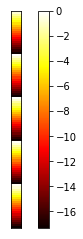

In [33]:
## display the Q-table approximated by the ANN
agent.display_q()

## Train

In [35]:
num_of_episodes = 100
rewards = agent.train(num_of_episodes)

AttributeError: 'Sequential' object has no attribute 'train'

## Improvements

The training could be improved by implementing the followings:
* batch training
* replay episodes/steps